## Colab: install deps

In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install git+https://github.com/mattclifford1/CLIME

# Pipeline for CLIME: Cost-sensitive LIME 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from clime import data, model, explainer, plot_utils, evaluation

22-Dec-15 18:43:27 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.
/home/matt/anaconda3/envs/clime/lib/python3.9/site-packages/fatf/vis/__init__.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Data 
Set up class samples

In [3]:
# setup class proportions
c1 = 25
c2 = 75
n_samples = c1 + c2
max_class = max(c1, c2)
class_proportions = [c1/max_class, c2/max_class]

Generate data

In [4]:
# generate data - moons or Guassian
balanced_train_data = data.get_moons(samples=n_samples)
# balanced_train_data = data.get_gaussian(samples=n_samples)

# get an unbalanced version of the dataset (uniform random removal of a class)
unbalanced_train_data = data.unbalance(balanced_train_data, class_proportions)

Plot the datasets

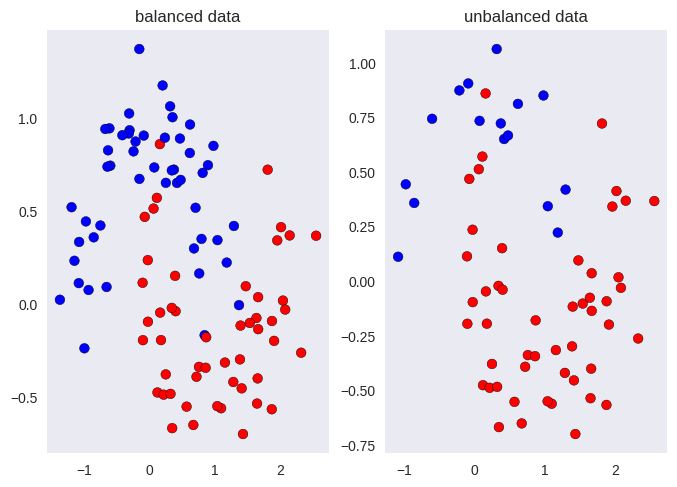

In [5]:
datasets = {
    'balanced data': balanced_train_data, 
    'unbalanced data': unbalanced_train_data,
#     'rebalanced data': data.balance(unbalanced_train_data, verbose=True),
    }
plot_utils.plot_data_dict(datasets)

# Model

In [6]:
clf = model.SVM(balanced_train_data)
clf_unbal = model.SVM(unbalanced_train_data)

plot the models' decision boundaries

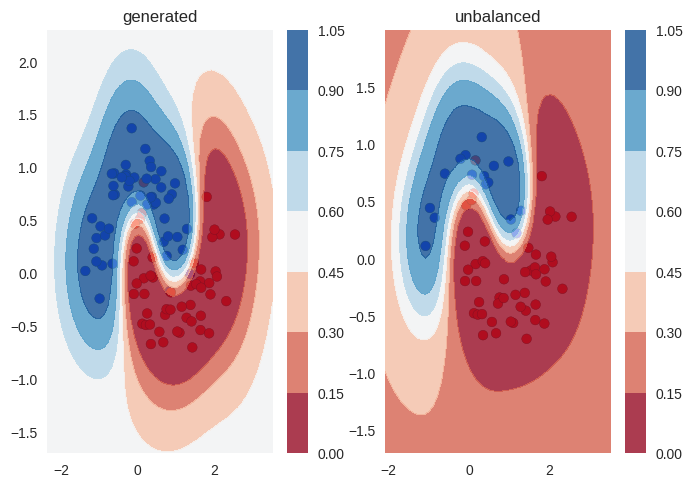

In [7]:
models = {
          'generated': {'model': clf, 'data': balanced_train_data}, 
          'unbalanced': {'model': clf_unbal, 'data': unbalanced_train_data}
         }
plot_utils.plot_clfs(models)

## Balanced training comparision

In [8]:
models = {
          'normal': {'model': clf_unbal, 'data': unbalanced_train_data}, 
          'weighted training': {'model': model.SVM(unbalanced_train_data, class_weight='balanced'), 'data': unbalanced_train_data},
          'boundary adjust': {'model': model.SVM_balance_boundary(unbalanced_train_data, boundary_weight=1), 'data': unbalanced_train_data},
          'probability adjust': {'model': model.SVM_balance_proba(unbalanced_train_data), 'data': unbalanced_train_data},
         }

plot adjusted classifiers

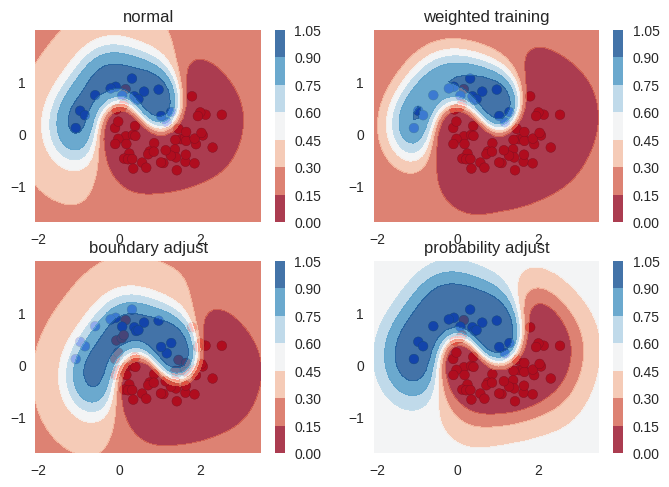

In [9]:
plot_utils.plot_clfs(models)

# Explainer

Original LIME

In [10]:
# lime = explainer.LIME(balanced_train_data, clf)
# lime_explanation = lime(balanced_train_data['X'][0, :])

# lime_unbal = explainer.LIME(unbalanced_train_data, clf_unbal)
# lime_explanation = lime_unbal(unbalanced_train_data['X'][0, :])

# lime.plot_explanation()
# lime_unbal.plot_explanation()

bLIMEy

In [13]:
query_point = unbalanced_train_data['X'][10, :]

blimey_bal = explainer.bLIMEy(clf, query_point)
blimey_unbal = explainer.bLIMEy(clf_unbal, query_point)

print(f'''
    Balanced explainer:   
        {blimey_bal.get_explanation()}, 
          fid: {evaluation.fidelity(blimey_bal, clf, balanced_train_data)}
          fid_local: {evaluation.local_fidelity(blimey_bal, clf, balanced_train_data, query_point)}
          ''')
print(f'Unbalanced explainer: {blimey_unbal.get_explanation()}')




    Balanced explainer:   [-0.1761775   0.25354878], 
          fid: 0.9
          fid_local: 0.8753383850347313
          
Unbalanced explainer: [-0.14121665  0.27747657]
